In [86]:
import bs4
from selenium import webdriver
import requests
import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import authentication
import praw
from psaw import PushshiftAPI
import datetime as dt
import json
import sys
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import ttest_ind

tqdm.pandas()
%matplotlib inline
plt.style.use('fivethirtyeight')


In [3]:
df = pd.read_csv('complete_final_dataframe_042720.csv')
df.head()

,id,title,date,username,url,author_flair,field,score,gilded,upvote_ratio,no_gilds_for_user,post_gilded,degree,length_of_title_words,length_of_title_char,average_word_length,time_of_day_PST,day_of_the_week
0,2r31gh,"A skull found in Montana, US belongs to the ea...",2015-01-01 23:59:50,presaging,http://www.bbc.com/earth/story/20141210-first-...,NaN,Paleontology,559,NaN,0.91,NaN,False,NaN,17.0,99.0,5.8,23,3
1,2r30hu,Schreiner Medipharm - Development Partner to P...,2015-01-01 23:44:49,David07z,http://www.packagingconnections.com/schreiner/,NaN,NaN,0,NaN,0.40,NaN,False,NaN,8.0,62.0,7.8,23,3
2,2r30bm,Omron image sensors designed to be 'eyes' of IoT,2015-01-01 23:42:48,mystypristy,http://www.pcworld.com/article/2824392/omron-i...,NaN,NaN,1,NaN,1.00,NaN,False,NaN,9.0,48.0,5.3,23,3
3,2r2z1w,X-Post from r/worldnews. Most cancer is caused...,2015-01-01 23:24:26,swill128,http://www.theguardian.com/society/2015/jan/01...,NaN,Epidemiology,0,[Comment(id='fo0d2i1')],0.54,1.0,False,NaN,15.0,83.0,5.5,23,3
4,2r2z0p,Upcoming google project Space elevator must re...,2015-01-01 23:23:53,babubro,https://www.trendcrackers.com/space-elevator-o...,NaN,Engineering,1,NaN,1.00,NaN,False,NaN,9.0,58.0,6.4,23,3


### Let's look at the correlation matrices for the numeric variables

In [4]:
df.corr('pearson')

,score,upvote_ratio,no_gilds_for_user,post_gilded,length_of_title_words,length_of_title_char,average_word_length,time_of_day_PST,day_of_the_week
score,1.000000,0.020342,0.153059,0.321579,0.187334,0.184984,-0.009573,-0.024450,0.010508
upvote_ratio,0.020342,1.000000,0.078950,0.005200,-0.112698,-0.123152,0.007510,-0.002712,0.026598
no_gilds_for_user,0.153059,0.078950,1.000000,0.005537,0.523756,0.525586,-0.044140,-0.114025,0.056964
post_gilded,0.321579,0.005200,0.005537,1.000000,0.060051,0.060401,-0.002341,-0.005028,0.001107
length_of_title_words,0.187334,-0.112698,0.523756,0.060051,1.000000,0.979885,-0.100690,-0.049385,-0.015419
length_of_title_char,0.184984,-0.123152,0.525586,0.060401,0.979885,1.000000,-0.005578,-0.047315,-0.015628
average_word_length,-0.009573,0.007510,-0.044140,-0.002341,-0.100690,-0.005578,1.000000,0.010628,0.007981
time_of_day_PST,-0.024450,-0.002712,-0.114025,-0.005028,-0.049385,-0.047315,0.010628,1.000000,0.003756
day_of_the_week,0.010508,0.026598,0.056964,0.001107,-0.015419,-0.015628,0.007981,0.003756,1.000000


In [5]:
df.corr('spearman')

,score,upvote_ratio,no_gilds_for_user,post_gilded,length_of_title_words,length_of_title_char,average_word_length,time_of_day_PST,day_of_the_week
score,1.000000,-0.274308,0.245496,0.073903,0.411055,0.440767,0.107921,-0.023123,-0.026776
upvote_ratio,-0.274308,1.000000,0.038510,-0.013611,-0.256641,-0.284863,-0.094930,-0.007625,0.035397
no_gilds_for_user,0.245496,0.038510,1.000000,0.003720,0.468508,0.474893,-0.027552,-0.101661,0.042444
post_gilded,0.073903,-0.013611,0.003720,1.000000,0.046436,0.047129,0.002185,-0.004039,0.001039
length_of_title_words,0.411055,-0.256641,0.468508,0.046436,1.000000,0.956341,-0.115471,-0.018853,-0.022138
length_of_title_char,0.440767,-0.284863,0.474893,0.047129,0.956341,1.000000,0.136198,-0.016712,-0.025404
average_word_length,0.107921,-0.094930,-0.027552,0.002185,-0.115471,0.136198,1.000000,0.005070,-0.012320
time_of_day_PST,-0.023123,-0.007625,-0.101661,-0.004039,-0.018853,-0.016712,0.005070,1.000000,-0.002017
day_of_the_week,-0.026776,0.035397,0.042444,0.001039,-0.022138,-0.025404,-0.012320,-0.002017,1.000000


## Distribution of length of title 

Text(0.5, 0, 'Number of words in title')

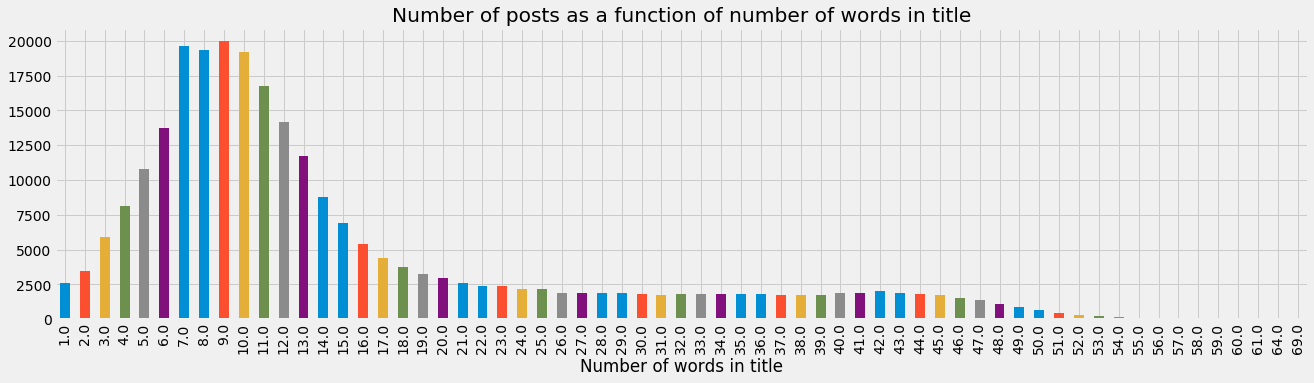

In [7]:
ax = df.length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')

### However, as soon as you remove posts that haven't scored very high, a peak at ~ 40 words appear

Text(0.5, 0, 'Number of words in title')

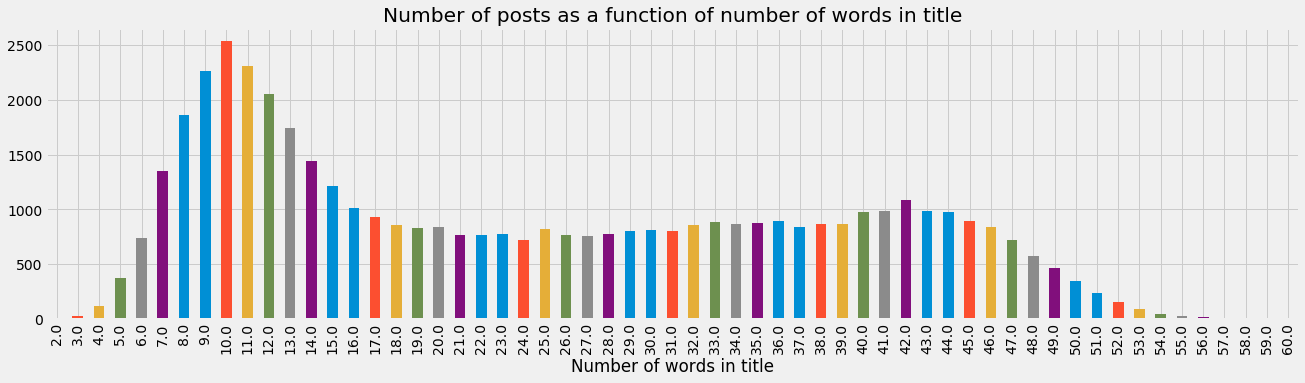

In [10]:
ax = df[df.score>20].length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')

Text(0.5, 0, 'Number of words in title')

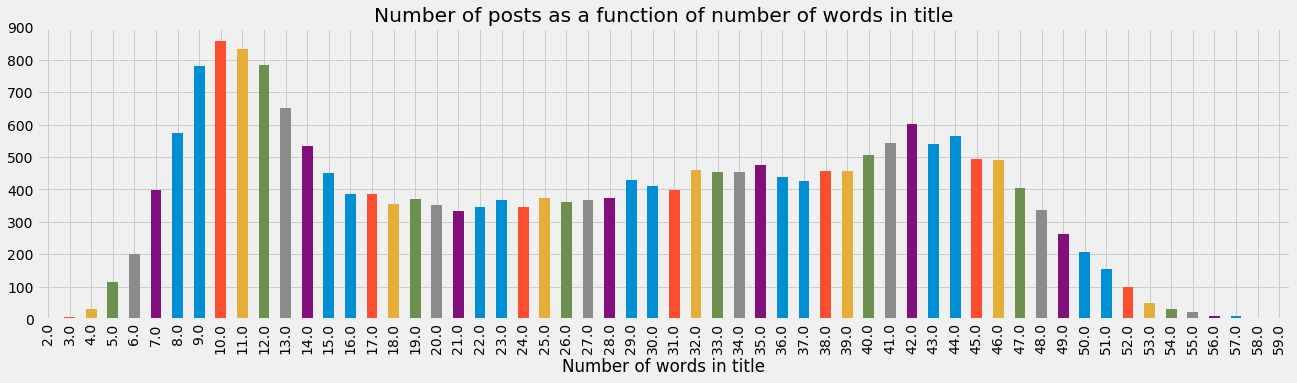

In [11]:
ax = df[df.score>100].length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')

Text(0.5, 0, 'Number of words in title')

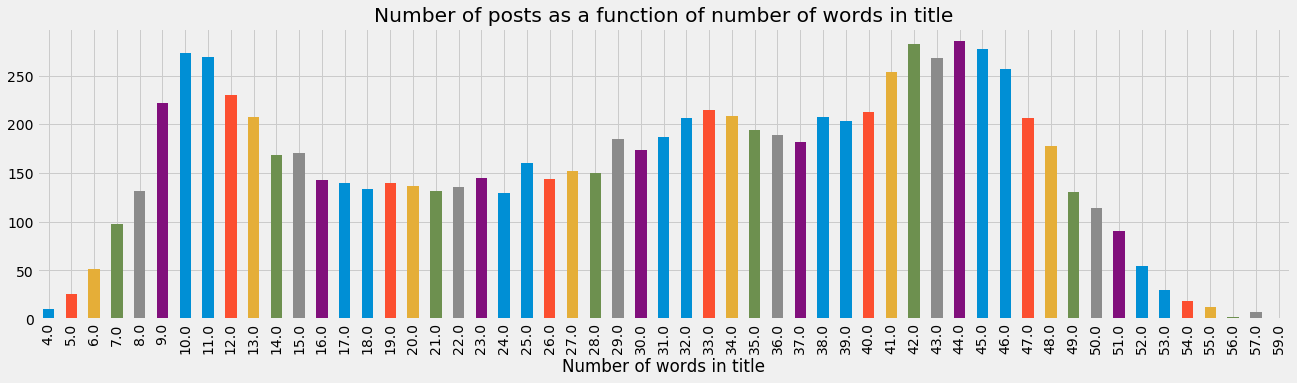

In [12]:
ax = df[df.score>1000].length_of_title_words.value_counts().sort_index().plot(kind='bar', figsize=(20,5))

ax.set_title('Number of posts as a function of number of words in title')
ax.set_xlabel('Number of words in title')

## Look at correlation of length of title with score
### Length of title and score seem to be fairly correlated (spearman corr ~ 0.44)

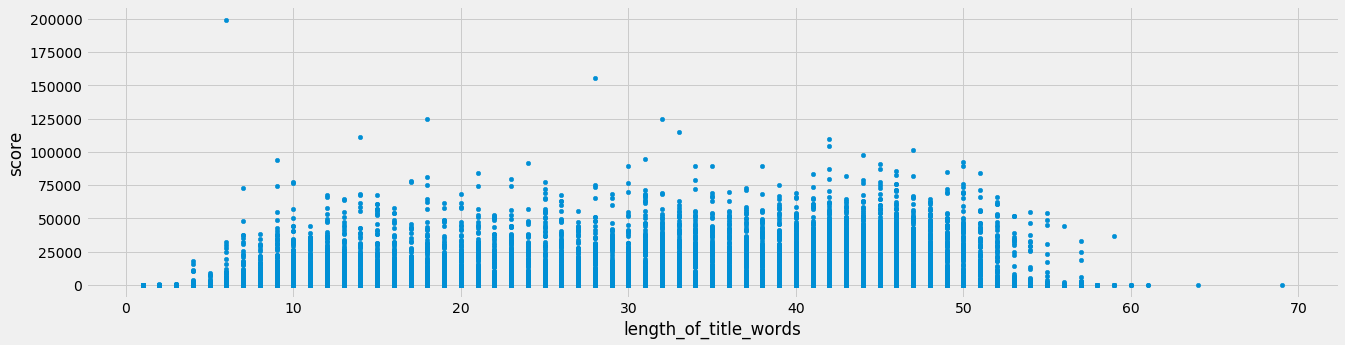

In [15]:
df.plot(kind='scatter', x='length_of_title_words', y='score', figsize=(20,5))

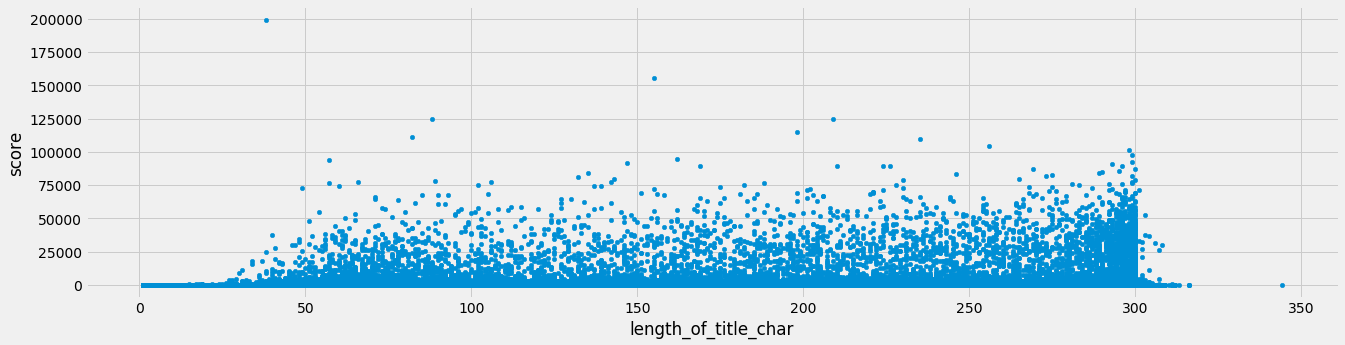

In [16]:
df.plot(kind='scatter', x='length_of_title_char', y='score', figsize=(20,5))

### The strength of this correlation isn't immediately obvious (to me) from those plots. 
Perhaps more so when the length of title is measured in characters

In [18]:
# Need to drop the rows where we have NaN values as that will throw the regressor off otherwise
correlation_df = df.copy()
correlation_df.dropna(subset=['length_of_title_words', 'length_of_title_char', 'score'], inplace=True)

In [20]:
# Very few rows have been removed from the parent df
correlation_df.shape

(256048, 18)

#### Let's try a linear regression with both length variables separately for now

In [24]:
X,y = np.array(correlation_df.length_of_title_words).reshape(-1,1), correlation_df.score
X_train, X_test, y_train, y_test = train_test_split(X,y)
lr = LinearRegression().fit(X_train, y_train)
print('training score: ', lr.score(X_train, y_train))
print('testing score: ', lr.score(X_test,y_test))

training score:  0.03444535520483205
testing score:  0.037041241328375496


#### That's a terrible score

In [26]:
# Score in comparison for the correlation betwen length of title words vs length of title char 
# (which are highly correlated)
X,y = np.array(correlation_df.length_of_title_words).reshape(-1,1), correlation_df.length_of_title_char
X_train, X_test, y_train, y_test = train_test_split(X,y)
lr = LinearRegression().fit(X_train, y_train)
print('training score: ', lr.score(X_train, y_train))
print('testing score: ', lr.score(X_test,y_test))

training score:  0.9601506089989315
testing score:  0.9602433867011704


### Let's replot score as a function of length of title in words, but let's compute the average of those values


In [138]:
plot_length_title_score_df = df[['score', 'length_of_title_words']].groupby('length_of_title_words')\
                                                                    .agg(['mean', 'std']).reset_index()

plot_length_title_score_df.columns = plot_length_title_score_df.columns.droplevel()

plot_length_title_score_df.rename(columns={'':'length_title_words', 'mean': 'mean_score'}, inplace=True)

plot_length_title_score_df.columns

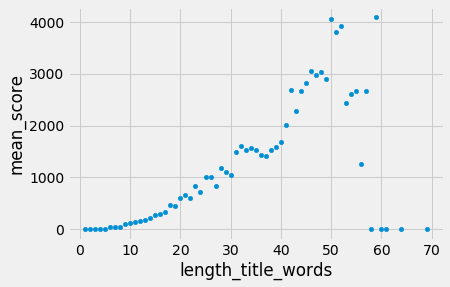

In [150]:
plot_length_title_score_df.plot(kind='scatter', x='length_title_words', y='mean_score')

It does look like a much neater correlation

### Let's put standard deviation on that

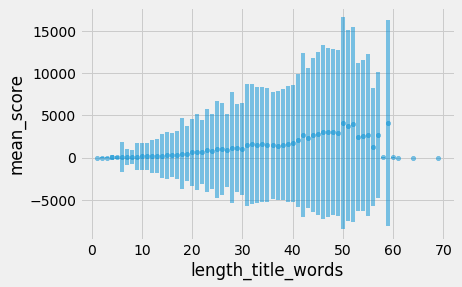

In [149]:
plot_length_title_score_df.plot(kind='scatter', x='length_title_words', y='mean_score', yerr=plot_length_title_score_df['std'], alpha=0.5)

### Error bars are huge

### Let's replot score as a function of length of title in chars, but let's compute the average of those values


In [186]:
plot_length_title_char_df = df[['score', 'length_of_title_char']].groupby('length_of_title_char')\
                                                                    .agg(['mean', 'std']).reset_index()

plot_length_title_char_df.columns = plot_length_title_char_df.columns.droplevel()

plot_length_title_char_df.rename(columns={'':'length_title_char', 'mean': 'mean_score'}, inplace=True)



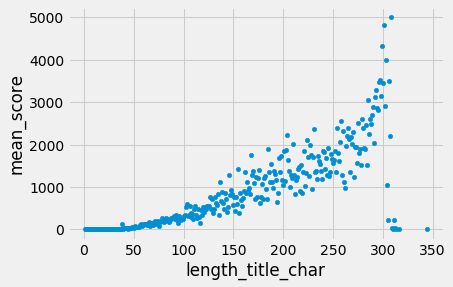

In [187]:
plot_length_title_char_df.plot(kind='scatter', x='length_title_char', y='mean_score')

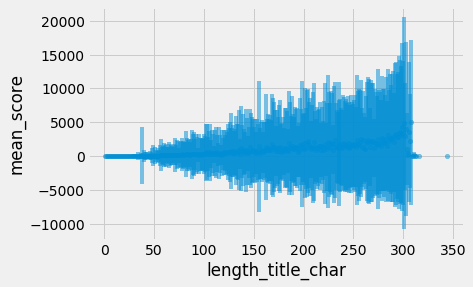

In [189]:
plot_length_title_char_df.plot(kind='scatter', x='length_title_char', y='mean_score', 
                               yerr=plot_length_title_char_df['std'], alpha=0.5)

### Error bars are huge

## Does daily time of posting have an influence on score? 

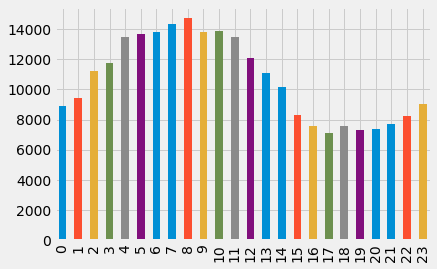

In [74]:
df.time_of_day_PST.value_counts().sort_index().plot(kind='bar')

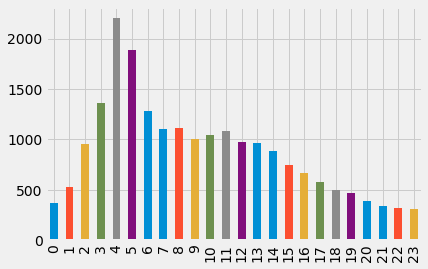

In [77]:
df[df.score>100].time_of_day_PST.value_counts().sort_index().plot(kind='bar')

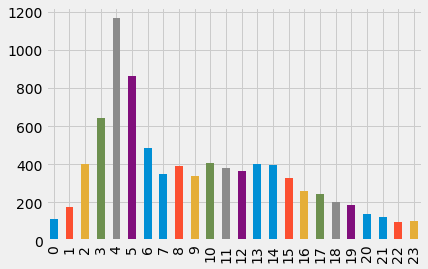

In [78]:
df[df.score>1000].time_of_day_PST.value_counts().sort_index().plot(kind='bar')

### You want to be posting around 4am PST time in order to score highly, i.e. when Europe is having lunch (+8 hours) and when the East Coast is waking up/going to work (+4 hours)¶


### Let's see what this looks like when plotting average of score as a function of time of day

In [163]:
time_of_day_df = df[['score', 'time_of_day_PST']].groupby('time_of_day_PST').agg(['mean', 'std']).reset_index()
time_of_day_df.columns = time_of_day_df.columns.droplevel()
time_of_day_df.rename(columns={'': 'time_of_day_PST', 'mean': 'mean_score'}, inplace=True)

In [164]:
time_of_day_df.columns

Index(['time_of_day_PST', 'mean_score', 'std'], dtype='object')

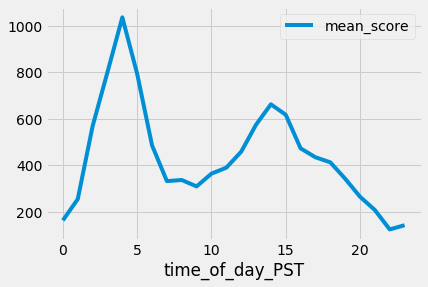

In [166]:
time_of_day_df.plot(kind='line', x='time_of_day_PST', y='mean_score')

### Mean score is influenced by time of posting

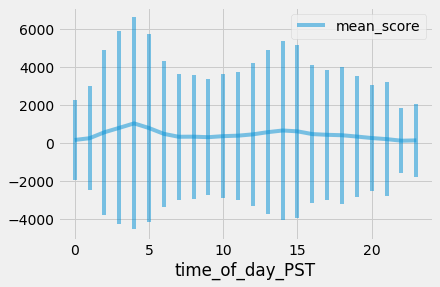

In [167]:
# Let's put some error bars on that
time_of_day_df.plot(kind='line', x='time_of_day_PST', y='mean_score', yerr=time_of_day_df['std'], alpha=0.5)

### Again, absolutely huge error bars

## Does weekly time of posting have an influence on score? 

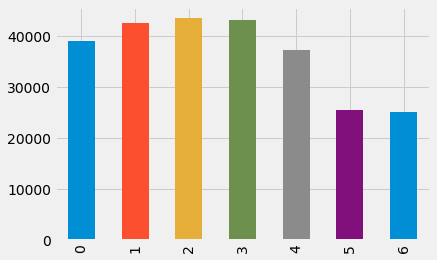

In [81]:
df.day_of_the_week.value_counts().sort_index().plot(kind='bar')

#### There is more activity during weekdays than during the week. Tuesday, wednesday and thursday are better


#### This difference is less pronounced for posts that score higher

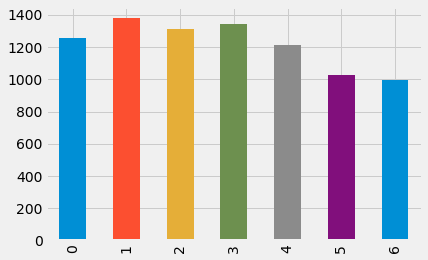

In [84]:
df[df.score>1000].day_of_the_week.value_counts().sort_index().plot(kind='bar')

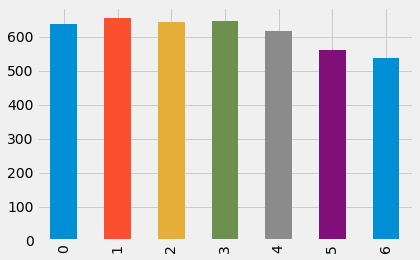

In [85]:
df[df.score>5000].day_of_the_week.value_counts().sort_index().plot(kind='bar')

### Will calculate statistical difference between score of submissions that are posted on different days of the week

In [169]:
time_of_week_df = df[['score', 'day_of_the_week']].groupby('day_of_the_week').agg(['mean', 'std']).reset_index()
time_of_week_df.columns = time_of_week_df.columns.droplevel()
time_of_week_df.rename(columns={'': 'day_of_the_week', 'mean': 'mean_score'}, inplace=True)

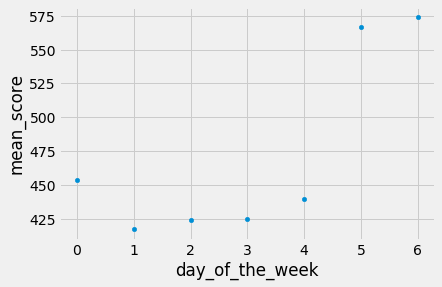

In [170]:
time_of_week_df.plot(kind='scatter', x='day_of_the_week', y='mean_score')

### Interesting, the posts that are posted on the weekend seem to score more highly. Need to look at error bars though

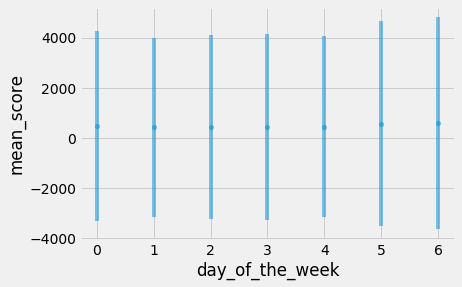

In [172]:
time_of_week_df.plot(kind='scatter', x='day_of_the_week', y='mean_score', yerr=time_of_week_df['std'], alpha=0.5)

### Again, error bars are monstrous, perhaps this would look a whole lot more different if we excluded low scoring posts from this analysis.

In [35]:
df.columns

Index(['id', 'title', 'date', 'username', 'url', 'author_flair', 'field',
       'score', 'gilded', 'upvote_ratio', 'no_gilds_for_user', 'post_gilded',
       'degree', 'length_of_title_words', 'length_of_title_char',
       'average_word_length', 'time_of_day_PST', 'day_of_the_week'],
      dtype='object')

## Relationship between average length of word and score of post

In [36]:
high_scoring_posts = df[df.score >= 10000].copy()
medium_scoring_posts = df[(500 <= df.score) & (df.score < 10000)].copy()
low_scoring_posts = df[df.score < 500].copy()



high_scoring_posts.dropna(subset=['average_word_length'], inplace=True)
medium_scoring_posts.dropna(subset=['average_word_length'], inplace=True)
low_scoring_posts.dropna(subset=['average_word_length'], inplace=True)


### What's the average word length in these 3 groups? 

In [43]:
print('High scoring posts, mean: ', np.average(high_scoring_posts.average_word_length))
print('High scoring posts, standard deviation: ', np.std(high_scoring_posts.average_word_length))

print('Medium scoring posts, mean: ', np.average(medium_scoring_posts.average_word_length))
print('Medium scoring posts, standard deviation: ', np.std(medium_scoring_posts.average_word_length))

print('Low scoring posts, mean: ', np.average(low_scoring_posts.average_word_length))
print('Low scoring posts, standard deviation: ', np.std(low_scoring_posts.average_word_length))

High scoring posts, mean:  6.401865907653384
High scoring posts, standard deviation:  0.6389079350799876
Medium scoring posts, mean:  6.462403639580438
Medium scoring posts, standard deviation:  0.7168641678548311
Low scoring posts, mean:  6.664207484090083
Low scoring posts, standard deviation:  3.281943578722985


In [38]:
# Are there any significant differences in average word length for these posts? 
print('medium/low difference:', ttest_ind(medium_scoring_posts.average_word_length,\
                                          low_scoring_posts.average_word_length))
print('medium/high difference:', ttest_ind(medium_scoring_posts.average_word_length,\
                                           high_scoring_posts.average_word_length))
print('high/low difference:', ttest_ind(low_scoring_posts.average_word_length,\
                                        high_scoring_posts.average_word_length))

medium/low difference: Ttest_indResult(statistic=-5.465536508625418, pvalue=4.6194298509861205e-08)
medium/high difference: Ttest_indResult(statistic=4.136853673326125, pvalue=3.547023787833014e-05)
high/low difference: Ttest_indResult(statistic=4.493750958412224, pvalue=7.001101787818209e-06)


### Very significant difference in average word length between the low, medium and high scoring groups

In [ ]:
# What does the distribution look like? 

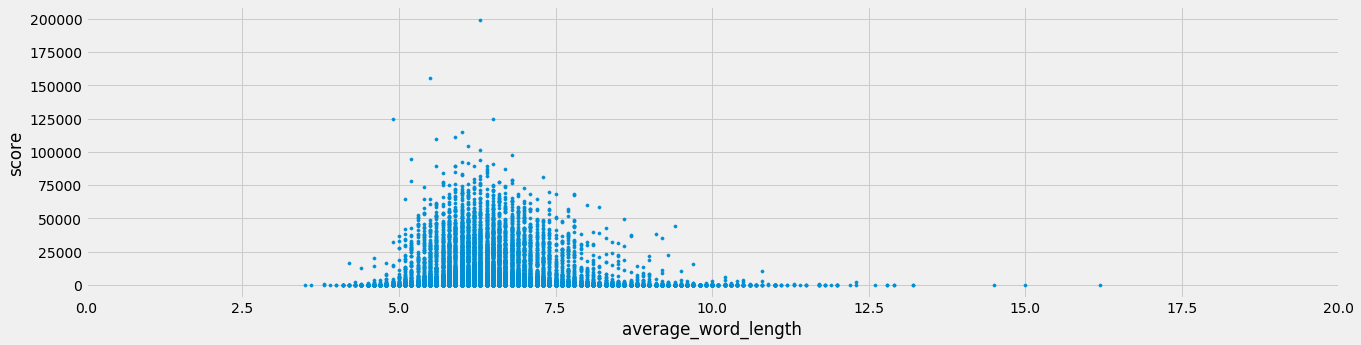

In [48]:
df[df.score>10].plot(kind='scatter',x='average_word_length', y='score', xlim=(0,20), s=10, figsize=(20,5))

#### Another way to look at this is to segment the average word length into bins, and see if there are any differences between those bins


In [54]:
df_length_word = df.copy()
df_length_word['average_word_length_bin'] = pd.cut(df_length_word.average_word_length,\
                                              bins=[x for x in np.arange(0,20,5)]).astype('str')

#### Is there a statistical significance between those different bins? I.e. a different way of looking at what was done previously
#### Look at score as a function of average word length for posts that have a score > 10

In [55]:
df_length_word[df_length_word.score > 10][['average_word_length_bin', 'score']].\
                                            groupby('average_word_length_bin').agg(['mean', 'std'])

score             
                                mean          std
average_word_length_bin                          
(0, 5]                    701.530337  5066.519097
(10, 15]                  270.248485  1050.829077
(5, 10]                  1906.788702  7518.026106
nan                        11.000000          NaN

In [56]:
short_words = df_length_word[(df_length_word.score > 10) & (df_length_word.average_word_length_bin == '(0, 5]')].\
                dropna(subset=['average_word_length_bin', 'score']).score
medium_words = df_length_word[(df_length_word.score > 10) & (df_length_word.average_word_length_bin == '(5, 10]')].\
                dropna(subset=['average_word_length_bin', 'score']).score
long_words = df_length_word[(df_length_word.score > 10) & (df_length_word.average_word_length_bin == '(10, 15]')].\
                dropna(subset=['average_word_length_bin', 'score']).score

In [57]:
print(ttest_ind(short_words,medium_words))
print(ttest_ind(medium_words, long_words))
print(ttest_ind(short_words, long_words))

Ttest_indResult(statistic=-4.766914905606371, pvalue=1.874920231685314e-06)
Ttest_indResult(statistic=2.7960819785176914, pvalue=0.00517423859605609)
Ttest_indResult(statistic=1.0887022749733766, pvalue=0.27653430157568076)


### This is a statistically signifcant difference

### How can those differences be so significant when the standard deviations are so huge? It doesn't make sense to me. Am I using the wrong statistical test? 

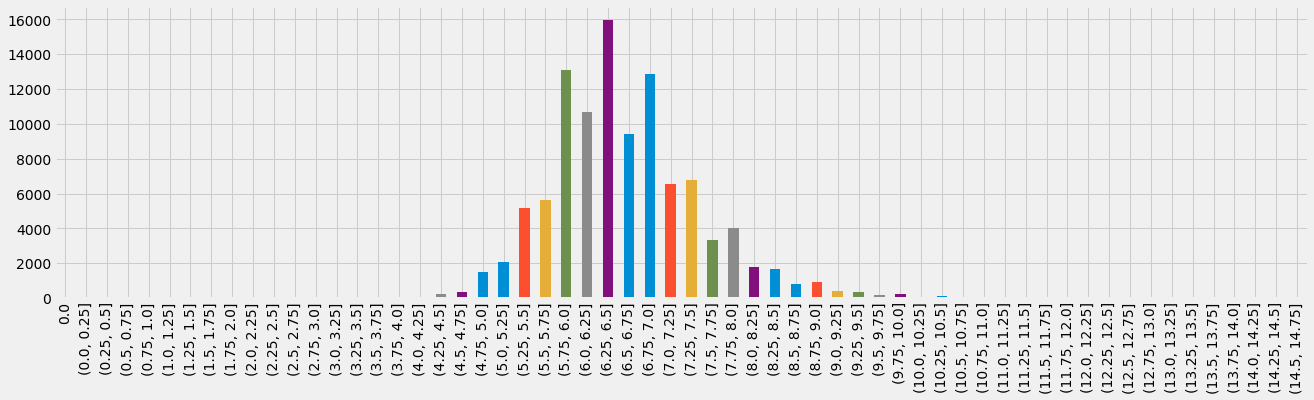

In [68]:
# Can look at the distribution of average word length with smaller bins
bins = [x for x in np.arange(0,15,0.25)]
for_plotting = pd.cut(df_length_word[df_length_word.score >= 2].average_word_length,\
                      bins).value_counts()
for_plotting.reindex(bins).plot(kind='bar', figsize=(20,5))


In [173]:
df.columns

Index(['id', 'title', 'date', 'username', 'url', 'author_flair', 'field',
       'score', 'gilded', 'upvote_ratio', 'no_gilds_for_user', 'post_gilded',
       'degree', 'length_of_title_words', 'length_of_title_char',
       'average_word_length', 'time_of_day_PST', 'day_of_the_week'],
      dtype='object')

### Let's replot this with averages, as opposed to a histogram

In [174]:
word_length_df = df[['score', 'average_word_length']].groupby('average_word_length').agg(['mean', 'std']).reset_index()
word_length_df.columns = word_length_df.columns.droplevel()
word_length_df.rename(columns={'': 'average_word_length', 'mean': 'mean_score'}, inplace=True)

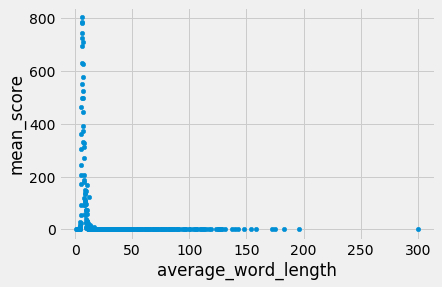

In [176]:
word_length_df.plot(kind='scatter', x='average_word_length', y='mean_score')

### Let's zoom in on this

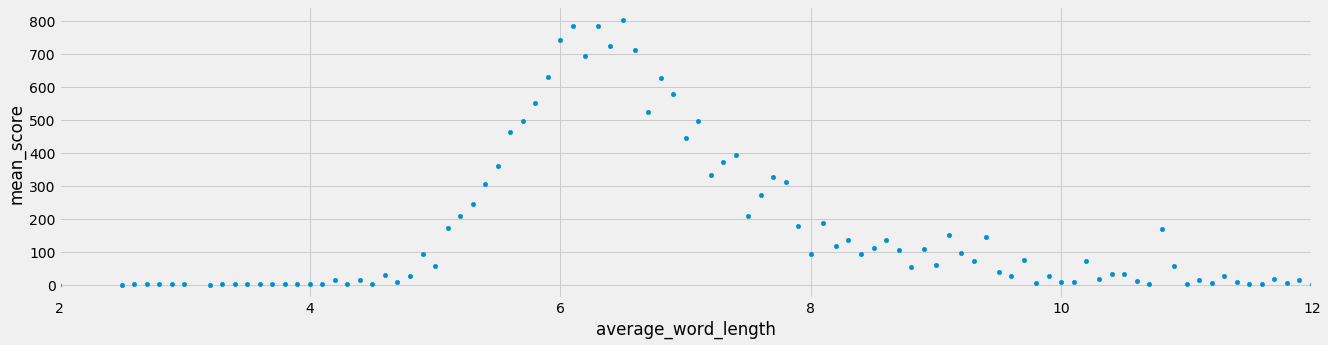

In [181]:
word_length_df.plot(kind='scatter', x='average_word_length', y='mean_score', xlim = (2,12), figsize=(20,5))

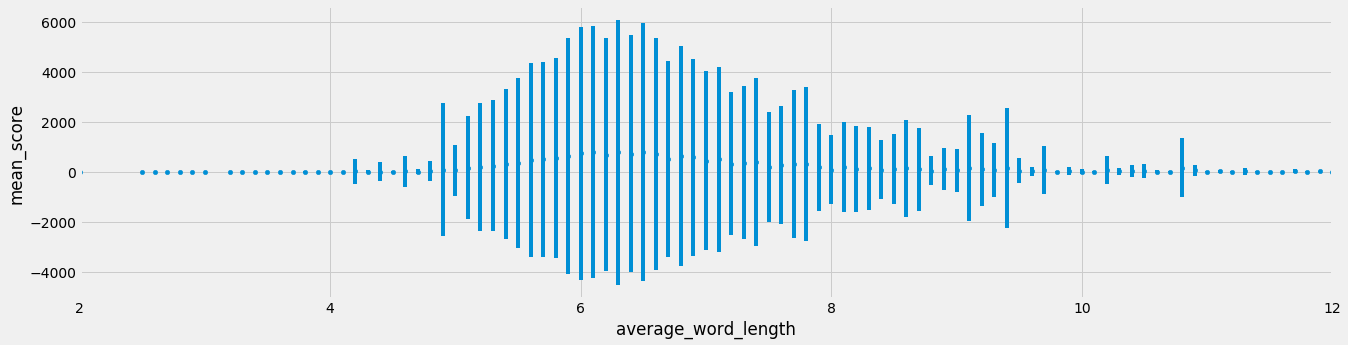

In [182]:
### Let's put some error bars on this

word_length_df.plot(kind='scatter', x='average_word_length', y='mean_score', xlim = (2,12), figsize=(20,5),
                   yerr= word_length_df['std'])

### Monstrous error bars

## Let's look at the differences in score between posters that show their degree

In [29]:
degree_df = df[['score','degree']].copy()
degree_df.degree = degree_df.degree.astype('str')
degree_df.groupby('degree').agg(['median','mean', 'std'])

score                            
          median          mean           std
degree                                      
Bachelors     15    784.482143   4149.172569
Master        20    756.117383   4086.537199
PhD           16   1203.244779   6064.226021
Professor    796  10558.095281  17367.066686
nan            1    302.937668   2903.232371

#### Median is considerably higher for professor than for any other degree

#### Similarly, there seems to be an increasing trend in the average score of the post as a function of degree of education, but the standard deviations are huge, so not sure it's meaningful

In [ ]:
# Let's use a SVM predicitve model to see if we can predict a user's degree type from their post

In [87]:
# SVM predictive model
# See if we can get a rough prediction of users' degree type using a SVC classifier
from sklearn import svm
classifier_df = df[df.degree.isna()==False].copy()

In [88]:
classifier_df.degree.value_counts()

PhD          4788
Professor    3327
Bachelors    1624
Master       1559
Name: degree, dtype: int64

In [89]:
classifier_df.columns

Index(['id', 'title', 'date', 'username', 'url', 'author_flair', 'field',
       'score', 'gilded', 'upvote_ratio', 'no_gilds_for_user', 'post_gilded',
       'degree', 'length_of_title_words', 'length_of_title_char',
       'average_word_length', 'time_of_day_PST', 'day_of_the_week'],
      dtype='object')

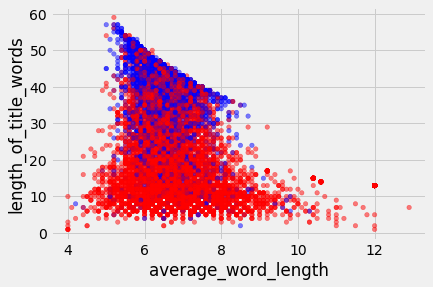

In [90]:
# Let's see how the data is distributed
color_map = {'PhD':'r', 'Professor':'b', 'Bachelors':'r', 'Master': 'r'}
colors = classifier_df.degree.map(color_map)
classifier_df.plot(kind='scatter', x='average_word_length', y='length_of_title_words', 
                  c=colors, alpha=0.5)

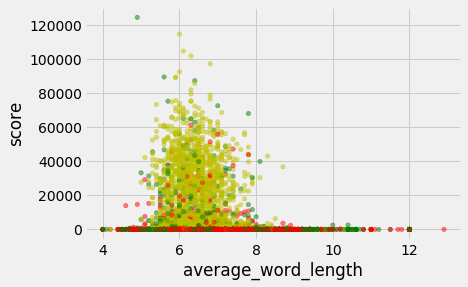

In [91]:
# Let's see how the data is distributed
color_map = {'PhD':'g', 'Professor':'y', 'Bachelors':'r', 'Master': 'r'}
colors = classifier_df.degree.map(color_map)
classifier_df.plot(kind='scatter', x='average_word_length', y='score', 
                  c=colors, alpha=0.5)

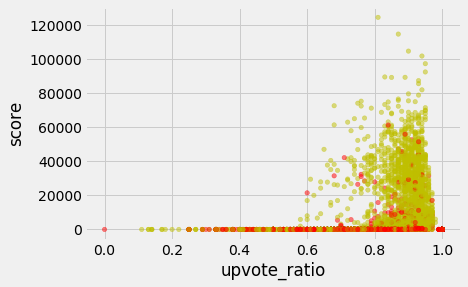

In [92]:
# Let's see how the data is distributed
color_map = {'PhD':'y', 'Professor':'y', 'Bachelors':'r', 'Master': 'r'}
colors = classifier_df.degree.map(color_map)
classifier_df.plot(kind='scatter', x='upvote_ratio', y='score', 
                  c=colors, alpha=0.5)

In [123]:
# What do we want to put in the classifier? 
# Let's start with score on its own

In [94]:
X = np.array([classifier_df.score]).reshape(-1,1)
y = np.array(classifier_df.degree)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Now train the model
clf = svm.SVC()
clf.fit(X_train, y_train)

# And now test it
sum(clf.predict(X_test) == y_test)/len(y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5454867256637168

### Score seems too be better than random assignment (which would have a 25% score)

### However, it looks like it's assigning very few masters/bachelors

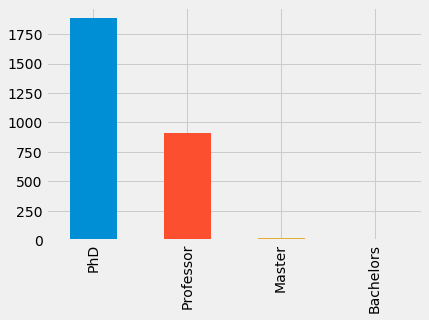

In [95]:
pd.Series(clf.predict(X_test)).value_counts().plot(kind='bar')

### Especially when compared to the original data

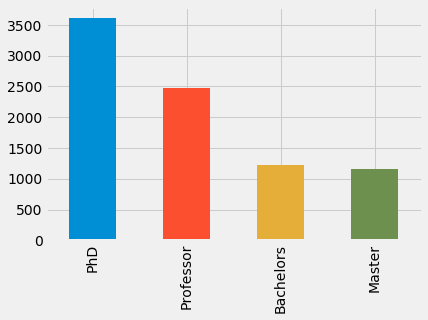

In [242]:
pd.Series(y_train).value_counts().plot(kind='bar')

#### Let's see if we can group PhD+Professor and discrimate against Bachelors/Master

### See if we can get higher accuracy with a two class approach, grouping professors + phd together and master + bachelor together

In [96]:

def is_Phd(row):
    if 'PhD' in row.degree or 'Professor' in row.degree: 
        return 'PhD'
    else:
        return 'Not PhD'
classifier_df['PhD_or_not'] = classifier_df.apply(is_Phd, axis=1)


In [97]:
X = np.array([classifier_df.score]).reshape(-1,1)
y = np.array(classifier_df.PhD_or_not)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Now train the model
clf = svm.SVC(gamma='auto')
clf.fit(X_train, y_train)

# And now test it
sum(clf.predict(X_test) == y_test)/len(y_test)

0.7178761061946902

### Initially this seems to be good, but it's actually no better than if you took the proportion of PhD in your training set and assigned 'PhD' to your testing set, with probability = proportion of PhD

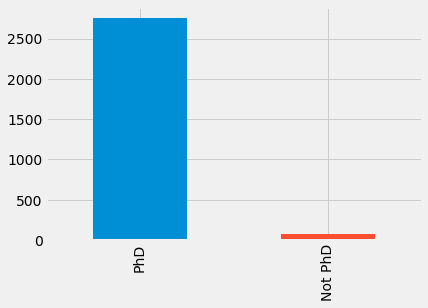

In [98]:
pd.Series(clf.predict(X_test)).value_counts().plot(kind='bar')

In [99]:
classifier_df.PhD_or_not.value_counts()

PhD        8115
Not PhD    3183
Name: PhD_or_not, dtype: int64

### 8115/(3183+8115) = 0.72 This is the proportion of PhDs in the data

In [195]:
# So our model is no better than a random model
test = np.random.choice(['PhD', 'Not PhD'], size=2825, p=[0.718,1-0.718])
sum(clf.predict(X_test) == test)/len(X_test)


0.7153982300884956

### What if we put in length of title in words + score + information about whether the post has received gold? Can we improve prediction? 

In [100]:
classifier_df.no_gilds_for_user.fillna(0, inplace=True)

In [101]:
classifier_df.replace({'post_gilded':
                       {True:'1', False:'0'}}, inplace=True)

In [265]:


X = classifier_df[['score', 'length_of_title_char', 'post_gilded']]

y = classifier_df.degree
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Now train the model
clf = svm.SVC(gamma='auto')
clf.fit(X_train, y_train)

# And now test it
sum(clf.predict(X_test) == y_test)/len(y_test)

0.5302654867256638

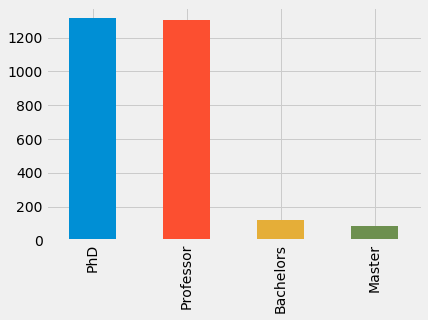

In [266]:
pd.Series(clf.predict(X_test)).value_counts().plot(kind='bar')

### With a prediction accuracy of 0.53, this doesn't work any better than the previous model, where score was the only predictor... 